In [1]:
import argparse
import logging
import os

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from train import train, train_and_evaluate
import matplotlib.pyplot as plt
from tifffile import imsave, TiffFile
from pathlib import Path

import utils
import model.net as net
from  model.data_loader import  fetch_dataloader
from evaluate import evaluate, predict

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Initial training

Let's start with a simple model:

- no augmentation (that is critical with such a small dataset);
- default learning rate;
- default optimizer (in the paper they use high momentum for a `batch_size = 1`); 

and so on.

### `params`

In [19]:
model_dir = 'experiments/initial_model'
json_path = os.path.join(model_dir, 'params.json')
params = utils.Params(json_path)

In [20]:
params.dict

{'learning_rate': 0.001,
 'batch_size': 1,
 'num_epochs': 25,
 'save_summary_steps': 100,
 'num_workers': 0}

### training

In [21]:
!python3 train.py --model_dir 'experiments/initial_model'

Loading the datasets...
- done.
Starting training for 25 epoch(s)
Epoch 1/25
100%|███████████████████████████████| 25/25 [00:02<00:00,  8.51it/s, loss=0.481]
- Train metrics: accuracy: 0.274 ; loss: 0.782
- Eval metrics : accuracy: 0.803 ; loss: 0.489
Checkpoint Directory exists! 
- Found new best accuracy
Epoch 2/25
100%|███████████████████████████████| 25/25 [00:02<00:00,  8.72it/s, loss=0.373]
- Train metrics: accuracy: 0.862 ; loss: 0.379
- Eval metrics : accuracy: 0.803 ; loss: 0.480
Checkpoint Directory exists! 
Epoch 3/25
100%|███████████████████████████████| 25/25 [00:02<00:00,  8.68it/s, loss=0.301]
- Train metrics: accuracy: 0.882 ; loss: 0.325
- Eval metrics : accuracy: 0.803 ; loss: 0.499
Checkpoint Directory exists! 
Epoch 4/25
100%|███████████████████████████████| 25/25 [00:02<00:00,  8.64it/s, loss=0.265]
- Train metrics: accuracy: 0.921 ; loss: 0.251
- Eval metrics : accuracy: 0.811 ; loss: 0.476
Checkpoint Directory exists! 
- Found new best accuracy
Epoch 5/25
100%|██

### plots

Let's now plot accuracy and loss.

In [22]:
history_path = os.path.join(model_dir, 'history.csv')

In [23]:
df = pd.read_csv(history_path)

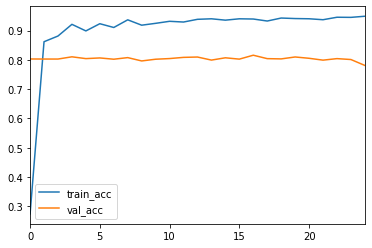

In [24]:
df[['train_acc', 'val_acc']].plot();

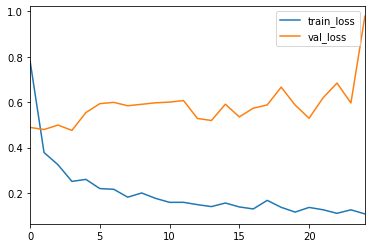

In [25]:
df[['train_loss', 'val_loss']].plot();

### prediction

In [26]:
params.cuda = torch.cuda.is_available()
dataloaders = fetch_dataloader(['test'], params)
test_dataloader = dataloaders['test']

In [27]:
len(test_dataloader)

30

In [28]:
model = net.Unet().cuda() if params.cuda else net.Unet()
checkpoint = os.path.join(model_dir, 'best.pth.tar')
utils.load_checkpoint(checkpoint, model);

In [29]:
preds = predict(model, test_dataloader)

In [30]:
preds.shape

(30, 1, 512, 512)

Let's save this `preds` as a `.tif` file.

In [31]:
imsave(os.path.join(model_dir, 'preds.tif'), preds)

Let's now visualize test image and prediction. 

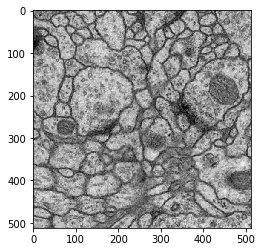

In [32]:
data_dir = Path.home() / 'data/isbi2012/'
images = TiffFile(data_dir / 'train-volume.tif').asarray()
plt.imshow(images[0], cmap='gray');

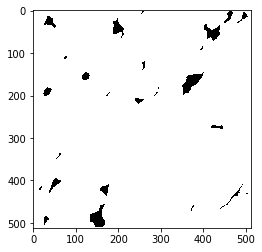

In [33]:
plt.imshow(preds[0].reshape(512, 512), cmap='gray');